In [1]:
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]

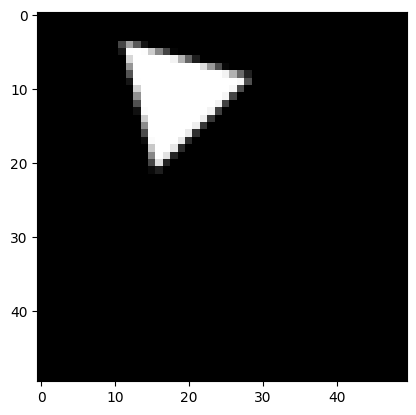

In [3]:
plt.imshow(X[5], cmap = 'gray')

In [4]:
X.shape

(10000, 50, 50)

In [5]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

In [6]:
#X_train_aug = np.concatenate([X_train, X_train[..., ::-1]])
#y_train_aug = np.concatenate([y_train, y_train])

In [ ]:
inp = keras.layers.Input(shape = (50, 50));
out = keras.layers.Flatten()(inp);
out = keras.layers.Dense(2000, activation = 'relu')(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(2000, activation = 'relu')(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(X, y, validation_split = 0.2, epochs = 50)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 50)]          0         
                                                                 
 flatten_7 (Flatten)         (None, 2500)              0         
                                                                 
 dense_34 (Dense)            (None, 2000)              5002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_35 (Dense)            (None, 2000)              4002000   
                                                                 
 dropout_1 (Dropout)         (None, 2000)              0         
                                                                 
 dense_36 (Dense)            (None, 1000)              2001

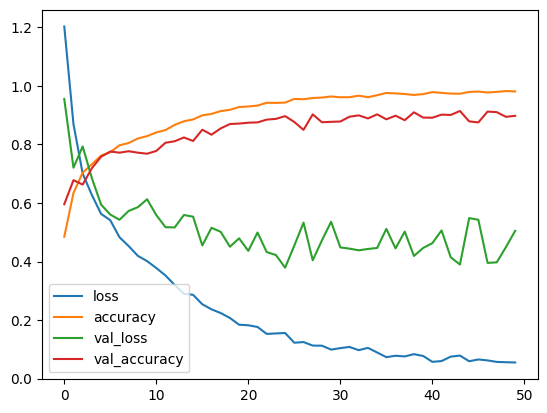

In [20]:
pd.DataFrame(hist.history).plot()
model.save('model.h5')